### Dependencies

1. OpenAI Python Library

In [ ]:
! pip install --upgrade openai

### Connect to Weaviate

In [ ]:
import weaviate, json
import weaviate.classes as wvc

client = weaviate.connect_to_local()

client.is_ready()

## Multimodal RAG

> Retreive Image → Pass to LMM (Large Multimodal Model) → Get Text/Image Output

### Step 1 – Retrieve content from the database with a query

Retrieved image object: {
  "mediaType": "image",
  "image": "/9j/4AAQSkZJRgABAQAASABIAAD/4QCMRXhpZgAATU0AKgAAAAgABQESAAMAAAABAAEAAAEaAAUAAAABAAAASgEbAAUAAAABAAAAUgEoAAMAAAABAAIAAIdpAAQAAAABAAAAWgAAAAAAAABIAAAAAQAAAEgAAAABAAOgAQADAAAAAQABAACgAgAEAAAAAQAAAsagAwAEAAAAAQAAAyAAAAAA/+0AOFBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/CABEIAyACxgMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAADAgQBBQAGBwgJCgv/xADDEAABAwMCBAMEBgQHBgQIBnMBAgADEQQSIQUxEyIQBkFRMhRhcSMHgSCRQhWhUjOxJGIwFsFy0UOSNIII4VNAJWMXNfCTc6JQRLKD8SZUNmSUdMJg0oSjGHDiJ0U3ZbNVdaSVw4Xy00Z2gONHVma0CQoZGigpKjg5OkhJSldYWVpnaGlqd3h5eoaHiImKkJaXmJmaoKWmp6ipqrC1tre4ubrAxMXGx8jJytDU1dbX2Nna4OTl5ufo6erz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAECAAMEBQYHCAkKC//EAMMRAAICAQMDAwIDBQIFAgQEhwEAAhEDEBIhBCAxQRMFMCIyURRABjMjYUIVcVI0gVAkkaFDsRYHYjVT8NElYMFE4XLxF4JjNnAmRVSSJ6LSCAkKGBkaKCkqNzg5OkZHSElKVVZXWFlaZGVmZ2hpanN0dXZ3eHl6gIOEhYaHiImKkJOUlZaXmJmaoKOkpaanqKmqsLKztLW2t7i5usDCw8TFxsfIycrQ09TV1tfY2drg4uPk5ebn6Onq8vP09fb3+Pn6/9sAQw

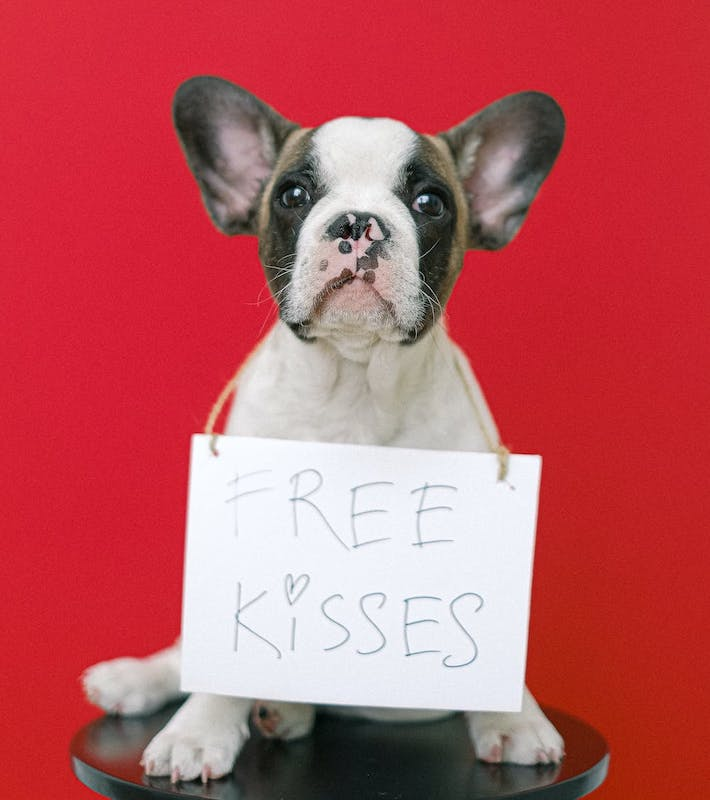

In [6]:
from IPython.display import Image

animals = client.collections.get("Animals")

def retrieve_image(query):
    response = animals.query.near_text(
        query=query,
        filters=wvc.Filter(path="mediaType").equal("image"),
        return_properties=['name','path','mediaType','image'],
        limit = 1,
    )
    result = response.objects[0].properties

    print("Retrieved image object:",json.dumps(result, indent=2))

    return result

# response = retrieve_image("animal on a log")
response = retrieve_image("dog with a sign")

SOURCE_IMAGE = response['image']

Image(response['path'])

### Step 2 - generate a description of the image

In [ ]:
import requests
import openai, os

openai.api_key = os.environ['OPENAI_API_KEY']

def generate_description_from_image_gpt4(prompt, image64):
  headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {openai.api_key}"
  }

  payload = {
      "model": "gpt-4-vision-preview",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            },
            {
              "type": "image_url",
              "image_url": {
                # "url": f"data:image/jpeg;base64,{response.objects[0].properties['image']}" #base64 encoded image from Weaviate
                "url": f"data:image/jpeg;base64,{image64}" #base64 encoded image from Weaviate
              }
            }
          ]
        }
      ],
      "max_tokens": 300
  }

  response_oai = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

  result = response_oai.json()['choices'][0]['message']['content']
  print(f"Generated description: {result}")

  return result


GENERATED_DESCRIPTION = generate_description_from_image_gpt4(
    prompt="This is an image of my pet, please give me a cute and vivid description.",
    image64=SOURCE_IMAGE
)

### Step 3 - use the image description to generate a new image with DALL·E 3

In [ ]:
from openai import OpenAI

def generate_image_dalee3(prompt):
  openai_client = OpenAI()

  response_oai = openai_client.images.generate(
    model="dall-e-3",
    prompt=str(prompt),
    size="1792x1024",
    quality="standard",
    n=1,
  )

  result = response_oai.data[0].url
  print (f"Generated image url: {result}")

  return result

image_url = generate_image_dalee3(GENERATED_DESCRIPTION)
Image(url=image_url)

## All together

In [ ]:
# Step 1 - retrieve an image – Weaviate
retrieved_image = retrieve_image("animal on a log")
SOURCE_IMAGE = retrieved_image['image']

# Step 2 - generate a description - GPT4
GENERATED_DESCRIPTION = generate_description_from_image_gpt4(
    prompt="This is an image of my pet, please give me a cute and vivid description.",
    image64=SOURCE_IMAGE
)

# Step 3 - use the description to generate a new image – DALE-E 3
GENERATED_IMAGE_URL = generate_image_dalee3(GENERATED_DESCRIPTION)

Image(url=str(GENERATED_IMAGE_URL))